In [1]:
from chromatic_fitting import *
from chromatic import Rainbow, SimulatedRainbow
from pymc3 import Normal, Uniform, Model, HalfNormal,Deterministic,  plot_trace, sample_prior_predictive, sample_posterior_predictive
from tqdm import tqdm
from pymc3_ext import eval_in_model, optimize, sample, ParameterGroup
from exoplanet import QuadLimbDark, ImpactParameter

plt.matplotlib.style.use('default')

Running on Python v3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:23:20) 
[Clang 12.0.1 ]
Running on numpy v1.22.3
Running on chromatic v0.1.5


In [2]:
# load simulated rainbow:
# r = Rainbow("test/b_withtransit_dw01.rainbow.npy")
# load Eureka! rainbow:
r_eureka = Rainbow("test/ERS_eureka/S3_nircam_wfss_template_ap8_bg16_Table_Save.txt")
# load jwst rainbow:
r_jwst = Rainbow("test/ERS_jwst/*x1dints.fits")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]


In [ ]:
binwave = 0.1
bintime = 5./60
r = r_eureka.bin(dw=binwave * u.micron, dt=bintime * u.hour)

# Create Synthetic Rainbow with Transit + Polynomial

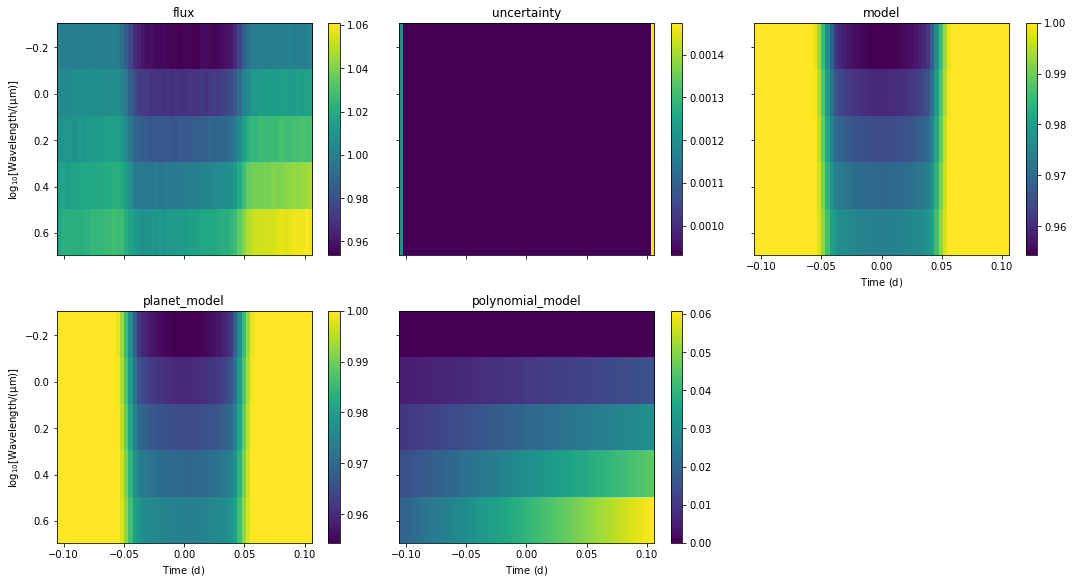

In [2]:
# create polynomial + transit rainbow:

r1 = SimulatedRainbow(signal_to_noise=100, dt=1 * u.minute, R=50)
r1 = r1.bin(nwavelengths=int(r1.nwave/5), dt=5 * u.minute)
poly=[]

# create wavelength-dep linear model:
for i in range(r1.nwave):
#     (0.5*i*(r1.time.to_value())**2) +
    poly.append((0.05*i*r1.time.to_value()) + (0.01*i))
r1.flux = r1.flux + poly

# add transit:
r = r1.inject_transit(
        planet_radius=np.linspace(0.2, 0.15, r1.nwave))
    
r.fluxlike['polynomial_model'] = np.array(poly)
r.imshow_quantities();

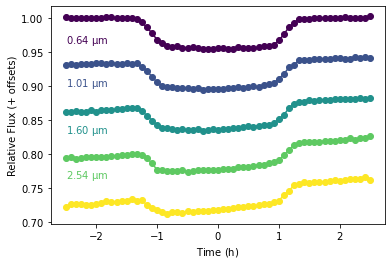

In [5]:
# plot 2d Lightcurves:
r.plot()

## White light curve

In [ ]:
wa = r.bin(nwavelengths=r.nwave)
wa.imshow()
wa.imshow_quantities()

# Polynomial Model

In [4]:
# set up polynomial model:
b = PolynomialModel()
b.initialize_empty_model()
b.setup_parameters(p=WavelikeFitted(Uniform,testval=[1,0.1],upper=[1.1,0.5],lower=[0.9,-0.05],shape=2))
b.summarize_parameters()
b.attach_data(r)
# if I setup_lightcurves for b before t it doesn't work!
b.setup_lightcurves()
# b.setup_likelihood()

p =
  <🧮 WavelikeFitted Uniform(testval=[1, 0.1], upper=[1.1, 0.5], lower=[0.9, -0.05], shape=2, name='p') for each wavelength 🧮>



# Transit Model

In [6]:
t = TransitModel()
t.initialize_empty_model()

t.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=1,
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05),
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.5, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=Fitted(QuadLimbDark,testval=[0.05,0.35]),
#                     baseline=b
                )

t.summarize_parameters()

stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_radius') 🧮>

stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_mass') 🧮>

radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.5, sigma=0.05, name='radius_ratio') for each wavelength 🧮>

period =
  <🧮 Fixed | 1 🧮>

epoch =
  <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='epoch') 🧮>

baseline =
  <🧮 Fixed | 1.0 🧮>

impact_parameter =
  <🧮 Fitted ImpactParameter(ror=0.15, testval=0.44, name='impact_parameter') 🧮>

limb_darkening =
  <🧮 Fitted QuadLimbDark(testval=[0.05, 0.35], name='limb_darkening') 🧮>



In [27]:
t.choose_optimization_method("white_light")
t.optimization

'white_light'

In [33]:
with t.model:
#     opt = optimize(start=t.model.test_point)
    trace = sample(tune=8000, draws=8000, cores=12, chains=4)
    summary = az.summary(trace, round_to=7, fmt='wide')
    print(summary)

Multiprocess sampling (4 chains in 12 jobs)
NUTS: [radius_ratio_w0, limb_darkening, stellar_mass, stellar_radius, impact_parameter, epoch]


Sampling 4 chains for 8_000 tune and 8_000 draw iterations (32_000 + 32_000 draws total) took 622 seconds.
There were 194 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7930286698770385, but should be close to 0.9. Try to increase the number of tuning steps.
There were 168 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8353381356355084, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


                       mean        sd    hdi_3%   hdi_97%  mcse_mean  \
radius_ratio_w0    0.100086  0.002364  0.095879  0.104405   0.000075   
epoch             -0.006940  0.000258 -0.007445 -0.006475   0.000009   
impact_parameter   0.423618  0.136442  0.138879  0.615621   0.004146   
stellar_radius     1.069961  0.064794  0.954558  1.182934   0.002491   
stellar_mass       1.004548  0.112830  0.816516  1.189174   0.001754   
limb_darkening[0]  0.474093  0.185202  0.111413  0.814169   0.005280   
limb_darkening[1]  0.230905  0.303452 -0.349714  0.741131   0.005343   

                    mcse_sd     ess_bulk     ess_tail     r_hat  
radius_ratio_w0    0.000054  1000.543583  1612.745681  1.007904  
epoch              0.000007   740.928258   394.409726  1.002740  
impact_parameter   0.003550   593.625111   738.420247  1.010257  
stellar_radius     0.001819   617.127116   397.545533  1.009860  
stellar_mass       0.001241  5123.765024  9536.795609  1.002512  
limb_darkening[0]  0.003735


🌈 Warning: Mean of empty slice.
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: Mean of empty slice.
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in log

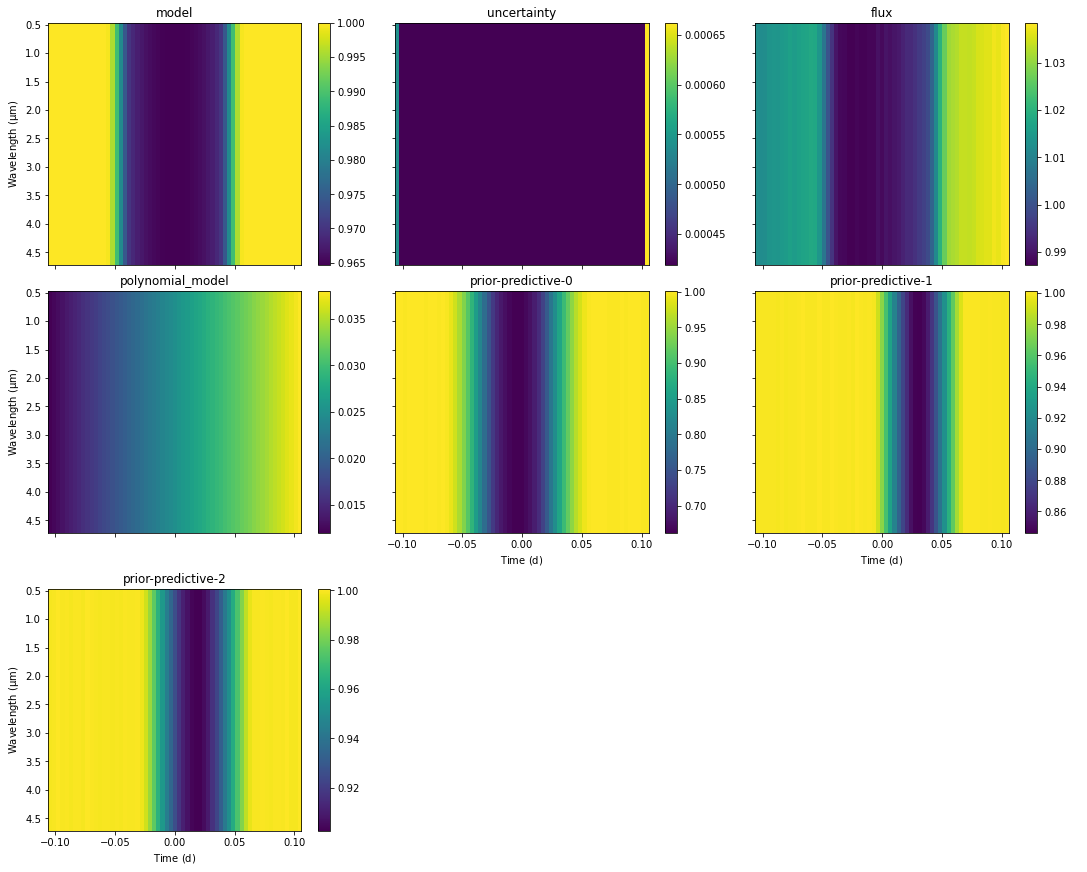

In [34]:
t.plot_priors()


🌈 Warning: Mean of empty slice.
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: Mean of empty slice.
🌈 Warning: invalid value encountered in double_scalars

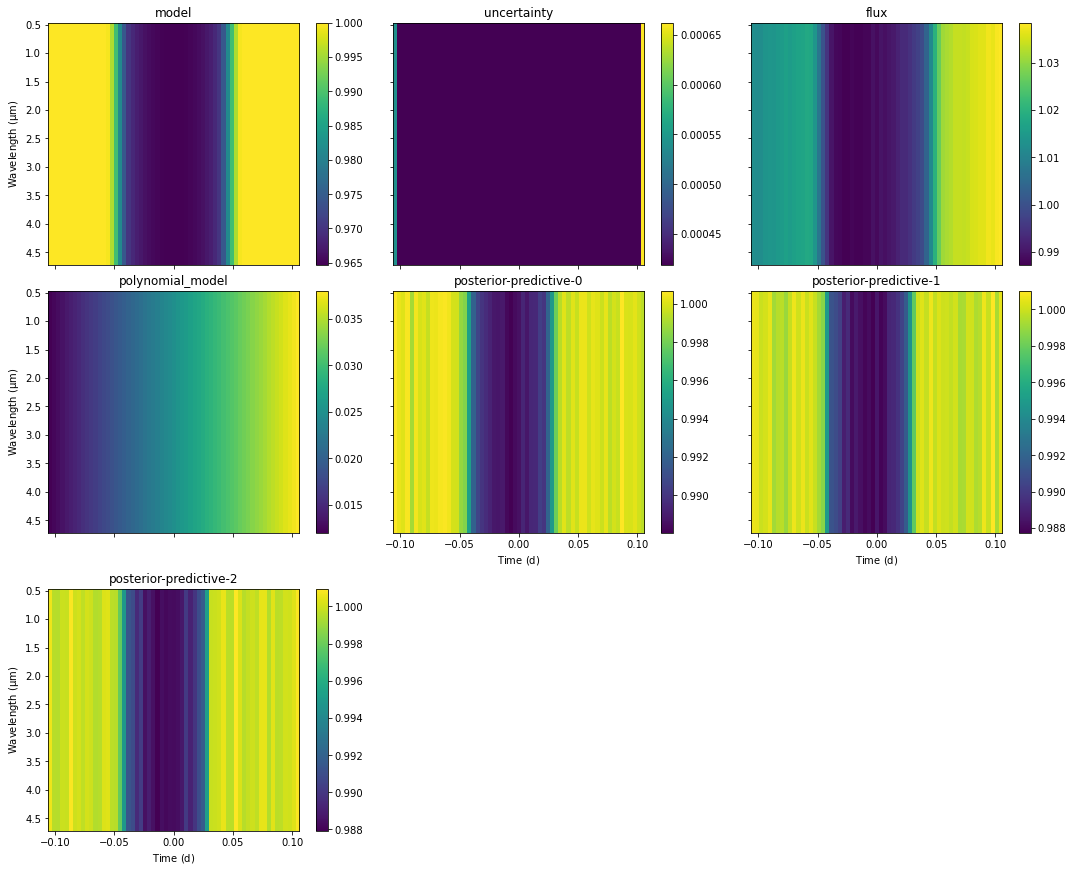

In [35]:
t.plot_posteriors(trace)

# Combined Model!

In [12]:
## combine the models!
cm = CombinedModel()
cm.initialize_empty_model()
## ^create pymc3 model - all constituent models link to main model
cm.attach_models({'transit':t,'polynomial':b})
print(cm.models_combined)
## change .model() to .pymc3model()
print(cm.parameters)
cm.attach_data(r)
cm.choose_optimization_method("white_light")
cm.setup_orbit()
cm.setup_lightcurves()
## ^setup_orbit() under setup_lightcurves()
cm.setup_likelihood()

{'transit': <experimental chromatic transit model 🌈>, 'polynomial': <experimental chromatic polynomial model 🌈>}
{'stellar_radius': <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_radius') 🧮>, 'stellar_mass': <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_mass') 🧮>, 'radius_ratio': <🧮 WavelikeFitted Normal(mu=0.5, sigma=0.05, name='radius_ratio') for each wavelength 🧮>, 'period': <🧮 Fixed | 1 🧮>, 'epoch': <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='epoch') 🧮>, 'baseline': <🧮 Fixed | 1.0 🧮>, 'impact_parameter': <🧮 Fitted ImpactParameter(ror=0.15, testval=0.44, name='impact_parameter') 🧮>, 'limb_darkening': <🧮 Fitted QuadLimbDark(testval=[0.05, 0.35], name='limb_darkening') 🧮>, 'p': <🧮 WavelikeFitted Uniform(testval=[1, 0.1], upper=[1.1, 0.5], lower=[0.9, -0.05], shape=2, name='p') for each wavelength 🧮>}


NameError: name 'xo' is not defined

In [14]:
cm.optimization

'simultaneous'

In [39]:
cm.models_combined['transit'].model


🌈 Warning: invalid value encountered in log

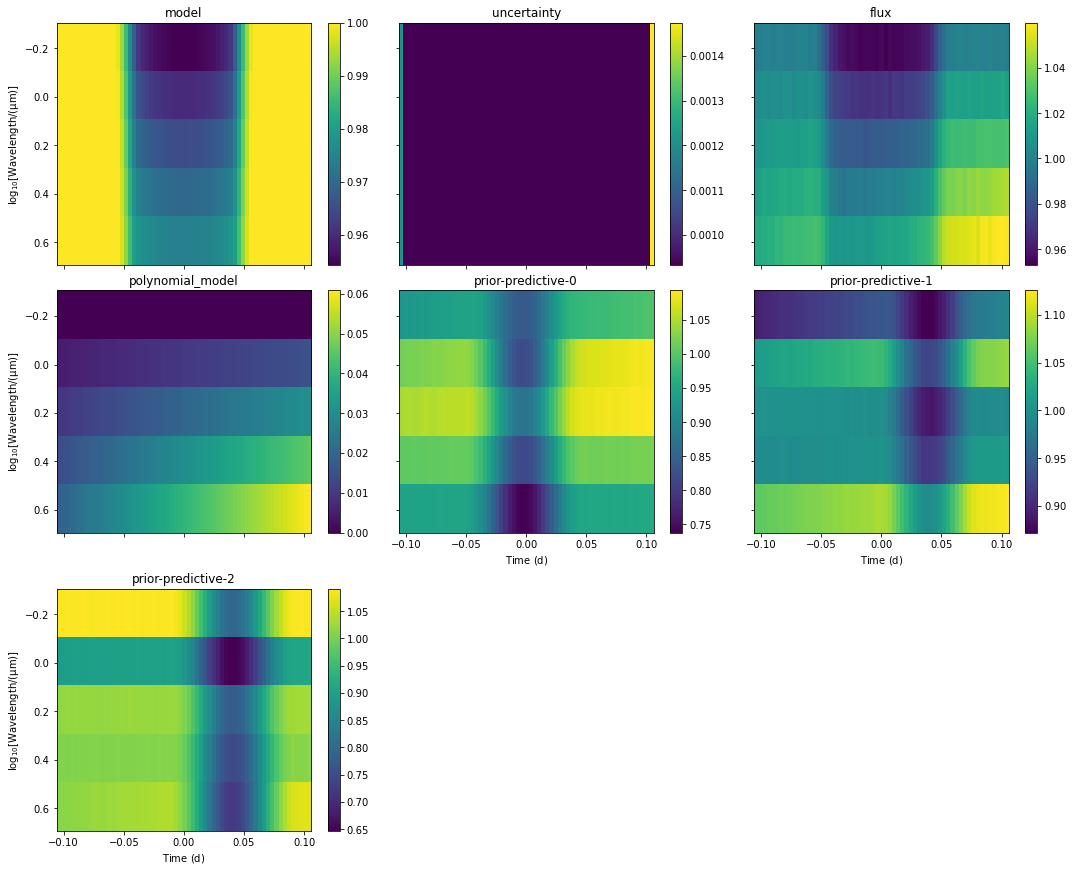

In [16]:
cm.plot_priors()

In [17]:
with cm.model:
#     opt = optimize(start=t.model.test_point)
    trace = sample(tune=8000, draws=8000, cores=12, chains=4)
    summary = az.summary(trace, round_to=7, fmt='wide')
    print(summary)

Multiprocess sampling (4 chains in 12 jobs)
NUTS: [p_w4, radius_ratio_w4, p_w3, radius_ratio_w3, p_w2, radius_ratio_w2, p_w1, radius_ratio_w1, p_w0, radius_ratio_w0, limb_darkening, stellar_mass, stellar_radius, impact_parameter, epoch]


Sampling 4 chains for 8_000 tune and 8_000 draw iterations (32_000 + 32_000 draws total) took 1219 seconds.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


                       mean        sd    hdi_3%   hdi_97%     mcse_mean  \
radius_ratio_w0    0.201453  0.001097  0.199425  0.203550  8.000000e-06   
radius_ratio_w1    0.190475  0.001061  0.188496  0.192506  7.900000e-06   
radius_ratio_w2    0.177885  0.001042  0.175897  0.179812  7.000000e-06   
radius_ratio_w3    0.165448  0.001025  0.163549  0.167395  6.700000e-06   
radius_ratio_w4    0.153799  0.001039  0.151887  0.155779  6.800000e-06   
epoch              0.000124  0.000077 -0.000021  0.000269  4.000000e-07   
impact_parameter   0.068956  0.049552  0.000004  0.158248  4.038000e-04   
stellar_radius     1.176630  0.014105  1.154032  1.199993  1.271000e-04   
stellar_mass       0.852180  0.030939  0.800058  0.901314  2.813000e-04   
limb_darkening[0]  0.300581  0.058137  0.195916  0.411656  4.204000e-04   
limb_darkening[1]  0.105800  0.132263 -0.141734  0.346429  1.019000e-03   
p_w0[0]            0.999932  0.000170  0.999612  1.000252  8.000000e-07   
p_w0[1]            0.0029

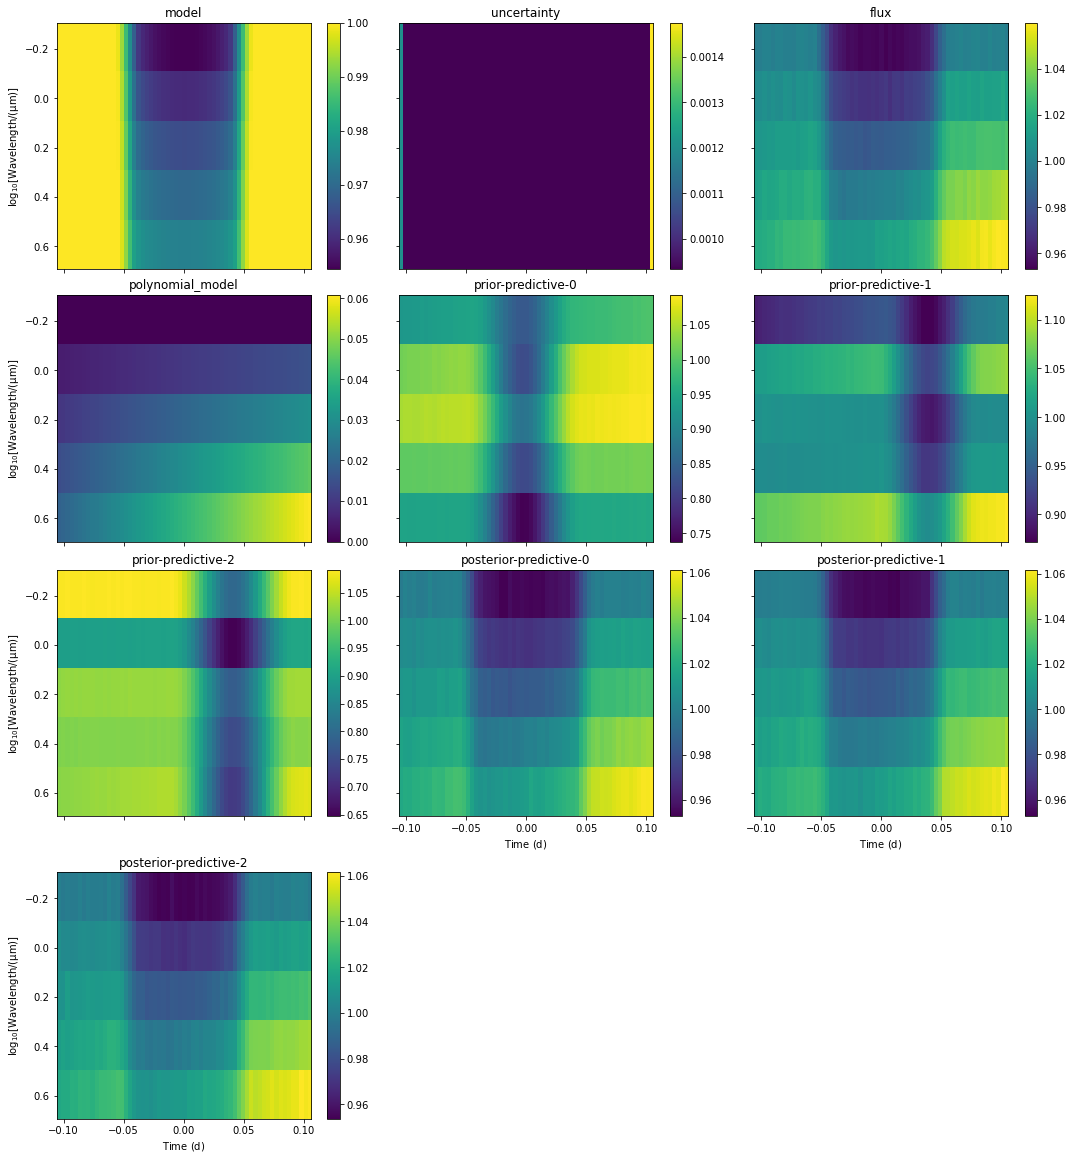

In [18]:
cm.plot_posteriors(trace)

In [20]:
cm_copy = cm

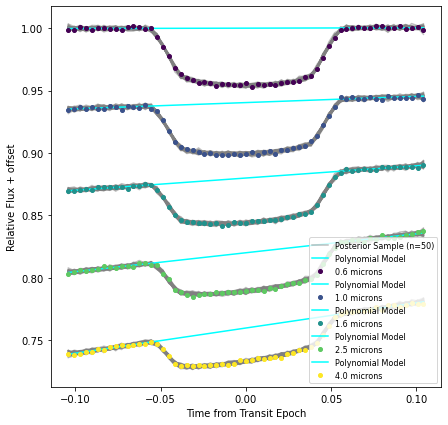

In [22]:
data = cm.get_data()
posterior_predictive_trace = cm.sample_posterior(trace, ndraws=50)
fig, ax = plt.subplots(figsize=(7,7))
from matplotlib.pyplot import cm as cmap
color=cmap.viridis(np.linspace(0,1,data.nwave))
firstplot = True
offset = 0
for w in range(data.nwave):
    poly = []
    for d in range(cm.degree+1):
        poly.append(summary['mean'][f"p_w{w}[{d}]"] * (data.time.to_value() ** d))
    polymodel = np.sum(poly,axis=0)

    for i in range(50):
        if firstplot:
            plt.plot(data.time, offset + posterior_predictive_trace[f'wavelength_{w}_data'][i],color='gray',alpha=0.5,label='Posterior Sample (n=50)')
            firstplot=False
        else:
            plt.plot(data.time, offset + posterior_predictive_trace[f'wavelength_{w}_data'][i],color='gray',alpha=0.5)
   
    plt.plot(data.time, offset + polymodel,c='cyan',label='Polynomial Model')
    plt.plot(data.time, offset + data.flux[w],linestyle="None", markersize=8, marker='.', color=color[w],label="%.1f microns"%data.wavelength[w].to_value())
    offset = offset-0.07
plt.ylabel("Relative Flux + offset")
plt.xlabel("Time from Transit Epoch")
plt.legend(loc='lower right',fontsize=8)

# Transit Model

In [ ]:
t = TransitModel()
t.initialize_empty_model()

t.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=4.055259,
                   epoch=Fitted(Uniform,lower=59782.95,upper=59783.05),
                   stellar_radius = Fitted(Uniform, lower=0.1, upper=2.0,testval=0.895),
                   stellar_mass =Fitted(Uniform, lower=0.1, upper=2.0,testval=0.93),
                   radius_ratio=WavelikeFitted(Normal, mu=0.15, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=WavelikeFitted(QuadLimbDark,testval=[0.05,0.35]),
                   baseline=WavelikeFitted(Normal,mu=1.0,sigma=0.0025))
t.summarize_parameters()

In [ ]:
t.setup_orbit()
t.attach_data(rn)
t.plot_orbit()
t.setup_lightcurves()
t.setup_likelihood()

In [ ]:
prior_predictive_trace = t.sample_prior(ndraws=3)
for i in range(3):
    flux_for_this_sample = np.array([prior_predictive_trace[f'wavelength_{w}_data'][i] for w in range(rn.nwave)])
    rn.fluxlike[f'prior-predictive-{i}'] = flux_for_this_sample
rn.imshow_quantities()

In [ ]:
vars_to_opt = [t.model[f"radius_ratio_w{w}"] for w in range(rn.nwave)]
print(vars_to_opt)

with t.model:
    opt = optimize(start=t.model.test_point)
    opt = optimize(start=opt, vars=vars_to_opt)
    trace = sample(start=opt,tune=8000, draws=8000, cores=12, chains=4)

In [ ]:
posterior_predictive_trace = t.sample_posterior(trace,ndraws=50)

In [ ]:
with t.model:
    summary = az.summary(trace, round_to=7, fmt='wide')
    print(summary)

In [ ]:
model_staticld, planet_params, wavelength,transmission = import_patricio_model()

plt.figure(figsize=(7,4))
plt.plot(wavelength,transmission*100,color='cyan',alpha=0.5,label='Spectrum Model')
for w in range(rn.nwave):
    rr = (summary['mean'][f"radius_ratio_w{w}"]**2)*100
    hdi3 = (summary['hdi_3%'][f"radius_ratio_w{w}"]**2)*100
    hdi97 = (summary['hdi_97%'][f"radius_ratio_w{w}"]**2)*100
    plt.plot(rn.wavelength[w],rr,'k.',markersize=6)
    plt.errorbar(rn.wavelength[w],rr, xerr=0.05*u.micron,
                 yerr=np.array([np.abs(hdi3-rr),np.abs(hdi97-rr)]).reshape((2,1)),c='k',alpha=0.5,capsize=3)

plt.ylabel("Transit Depth [%]")
plt.xlabel("Wavelength [microns]")
plt.xlim(2,4.5)
plt.legend()
plt.show()

In [ ]:
planet_params

In [ ]:
fig, ax = plt.subplots(figsize=(7,10))
from matplotlib.pyplot import cm
color=cm.viridis(np.linspace(0,1,rn.nwave))
firstplot = True
offset = 0
for w in range(rn.nwave):
    for i in range(50):
        if firstplot:
            plt.plot(rn.time, offset + posterior_predictive_trace[f'wavelength_{w}_data'][i],color='gray',alpha=0.5,label='Posterior Sample\n (n=50)')
            firstplot=False
        else:
            plt.plot(rn.time, offset + posterior_predictive_trace[f'wavelength_{w}_data'][i],color='gray',alpha=0.5)
    plt.plot(rn.time, offset + rn.flux[w],linestyle="None", markersize=8, marker='.', color=color[w],label="%.1f microns"%rn.wavelength[w].to_value())
    offset = offset-0.04
plt.ylabel("Relative Flux + offset")
plt.xlabel("Time from Transit Epoch")
plt.legend(loc='upper right',fontsize=8)